<a href="https://www.kaggle.com/datasets/ruizgara/socofing">Sokoto Coventry Fingerprint Dataset</a> (SOCOFing) 은 지문 인식과 보안 연구를 위해 만들어진 공개 데이터셋으로, 6,000명 이상으로부터 수집된 66,000여 개의 흑백 지문 이미지를 포함합니다. 이 데이터셋은 원본 지문뿐 아니라 Easy, Medium, Hard 수준으로 합성 변형된 지문도 함께 제공하여, 신분 인증뿐 아니라 위조 지문 탐지(Spoof Detection) 연구에도 활용됩니다. 따라서 딥러닝 기반의 지문 분류, 식별, 보안 시스템 개발을 위한 중요한 벤치마크 자료로 널리 사용됩니다.

In [4]:
import os
import shutil

# Create .kaggle directory if it doesn't exist
if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')

# Move the uploaded file and set permissions
if os.path.exists('kaggle.json'):
    shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 600)
    print("Kaggle API key setup complete.")
else:
    print("kaggle.json not found. Please upload the file first.")

Kaggle API key setup complete.


In [5]:
!kaggle datasets download ruizgara/socofing

Dataset URL: https://www.kaggle.com/datasets/ruizgara/socofing
License(s): other
 95% 792M/838M [00:07<00:00, 100MB/s] 
100% 838M/838M [00:07<00:00, 111MB/s]


In [6]:
!unzip -q socofing.zip

In [7]:
import json
import os
import shutil
from PIL import Image
from tqdm import tqdm

In [8]:
data_root = '/content/socofing/SOCOFing'

In [9]:
'''
    원본 이미지 : Real 폴더
    비교 이미지 : Altered 폴더

    일치하는 쌍 (positive pair) : [(원본 이미지1, 비교 이미지1), (원본 이미지2, 비교 이미지2), ...]
    불일치 하는 쌍 (negative pair) : [(원본 이미지1, 비교 이미지3), (원본 이미지2, 비교 이미지14), ...]
'''

src_filename_list = []
dst_filename_list = []
for filename in os.listdir(os.path.join(data_root, 'Real')):
    if filename.endswith('BMP'):
        src_filename_list.append(filename)

        '''
            파일명에 (_Obl, _Zcut, _CR)을 포함하는  들어있는 파일 쌍을 같은 인덱스에 저장하기
        '''
        dst_filename_list.append(
            (
                f"{filename.split('.')[0]}_Zcut.BMP",
                f"{filename.split('.')[0]}_Obl.BMP",
                f"{filename.split('.')[0]}_CR.BMP"
            )
        )
    else:
        continue

In [10]:
print(src_filename_list[:2])
print(dst_filename_list[:2])

['114__F_Left_index_finger.BMP', '83__M_Right_middle_finger.BMP']
[('114__F_Left_index_finger_Zcut.BMP', '114__F_Left_index_finger_Obl.BMP', '114__F_Left_index_finger_CR.BMP'), ('83__M_Right_middle_finger_Zcut.BMP', '83__M_Right_middle_finger_Obl.BMP', '83__M_Right_middle_finger_CR.BMP')]


In [11]:
import random
'''
    파일명의 조합으로 positive pair를 생성한다.
'''

positive_pair_list = []
## 동일한 파일끼리의 매칭
for src_filename in src_filename_list:
    src_path = os.path.join(data_root, 'Real', src_filename)
    positive_pair_list.append(
        (src_path, src_path, 0)
    )
print("동일 이미지 매칭 개수 :", len(positive_pair_list))

dst_dir_list = ['Altered-Easy', 'Altered-Hard', 'Altered-Medium']
for src_filename, dst_filenames in zip(src_filename_list, dst_filename_list):
    for dst_fname in dst_filenames:
        for dst_dir in dst_dir_list:
            src_path = os.path.join(data_root, 'Real', src_filename)
            dst_path = os.path.join(data_root, 'Altered', dst_dir,  dst_fname)

            ## 파일이 없을 경우 생략한다.
            if (not os.path.exists(src_path)) or (not os.path.exists(dst_path)):
                continue
            positive_pair_list.append(
                (src_path, dst_path, 0)
            )
print("src, dst 이미지 매칭 개수 :", len(positive_pair_list))

동일 이미지 매칭 개수 : 6000
src, dst 이미지 매칭 개수 : 55270


In [12]:
import random

'''
    파일명의 조합으로 negative pair를 생성한다.
'''
negative_pair_list = []
dst_dir_list = ['Altered-Easy', 'Altered-Hard', 'Altered-Medium']

'''
    src 파일끼리 negative 매칭
'''
for i in tqdm(range(len(src_filename_list))):
    for j in range(i+1, len(src_filename_list)):
        if random.randint(1, 3) != 1: ## 30%의 데이터만 매칭함
            continue
        src_filename1 = src_filename_list[i]
        src_filename2 = src_filename_list[j]
        src1_path = os.path.join(data_root, 'Real', src_filename1)
        src2_path = os.path.join(data_root, 'Real', src_filename2)
        negative_pair_list.append(
            [src1_path, src2_path, 1]
        )
print("src 이미지 매칭 개수 :", len(negative_pair_list))

'''
    src, dst 파일간의 negative 매칭
'''
for src_filename in tqdm(src_filename_list): ## src 이미지
    random_dst_filename_list = random.sample(dst_filename_list, 100) ## 랜덤하게 100개만 추출하여 매칭
    for dst_filenames in random_dst_filename_list:
        rand_idx = random.randint(0, 2) ## 랜덤으로 한 개 선택
        dst_fname = dst_filenames[rand_idx]
        if src_filename in dst_fname: ## 같은 지문은 매칭에서 제외한다. (negative pair 생성)
            continue
        for dst_dir in dst_dir_list:
            src_path = os.path.join(data_root, 'Real', src_filename)
            dst_path = os.path.join(data_root, 'Altered', dst_dir,  dst_fname)

            ## 파일이 없을 경우 생략한다.
            if (not os.path.exists(src_path)) or (not os.path.exists(dst_path)):
                continue
            negative_pair_list.append(
                [src_path, dst_path, 1]
            )
print("src, dst 이미지 매칭 개수 :", len(negative_pair_list))

100%|██████████| 6000/6000 [00:30<00:00, 194.95it/s] 


src 이미지 매칭 개수 : 5998366


100%|██████████| 6000/6000 [00:18<00:00, 325.81it/s]

src, dst 이미지 매칭 개수 : 7640936


In [13]:
print(f"전체 positive pair 개수 : {len(positive_pair_list)}")
print(f"전체 negative pair 개수 : {len(negative_pair_list)}")

전체 positive pair 개수 : 55270
전체 negative pair 개수 : 7640936


In [14]:
'''
    negative pair의 개수를 positive pair의 개수와 맞추기
'''
sampled_negative_pair_list = random.sample(negative_pair_list, len(positive_pair_list))

annotations = positive_pair_list + sampled_negative_pair_list
random.shuffle(annotations) ## 데이터 셔플
print(f"전체 positive pair 개수 : {len(positive_pair_list)}")
print(f"샘플링 한 negative pair 개수 : {len(sampled_negative_pair_list)}")
print(f"전체 데이터 개수 : {len(annotations)}")

전체 positive pair 개수 : 55270
샘플링 한 negative pair 개수 : 55270
전체 데이터 개수 : 110540


In [15]:
annotations[0:10]

[['/content/socofing/SOCOFing/Real/187__M_Right_middle_finger.BMP',
  '/content/socofing/SOCOFing/Real/343__M_Right_thumb_finger.BMP',
  1],
 ['/content/socofing/SOCOFing/Real/95__M_Right_ring_finger.BMP',
  '/content/socofing/SOCOFing/Real/165__M_Right_middle_finger.BMP',
  1],
 ('/content/socofing/SOCOFing/Real/309__M_Left_thumb_finger.BMP',
  '/content/socofing/SOCOFing/Altered/Altered-Hard/309__M_Left_thumb_finger_CR.BMP',
  0),
 ('/content/socofing/SOCOFing/Real/76__F_Left_thumb_finger.BMP',
  '/content/socofing/SOCOFing/Real/76__F_Left_thumb_finger.BMP',
  0),
 ('/content/socofing/SOCOFing/Real/197__M_Left_thumb_finger.BMP',
  '/content/socofing/SOCOFing/Altered/Altered-Medium/197__M_Left_thumb_finger_Zcut.BMP',
  0),
 ['/content/socofing/SOCOFing/Real/313__M_Right_middle_finger.BMP',
  '/content/socofing/SOCOFing/Altered/Altered-Easy/214__M_Left_middle_finger_CR.BMP',
  1],
 ('/content/socofing/SOCOFing/Real/215__M_Left_thumb_finger.BMP',
  '/content/socofing/SOCOFing/Altered/Al

In [16]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

In [18]:
'''
    pair 데이터를 파싱하는 데이터세트 클래스를 생성한다.
'''

class PairDataset(Dataset):
    def __init__(self,
                 annotations,
                 transform=None):
        self.annotations = annotations
        self.transform = transform
        self.class_list = [0, 1]
        self.num_classes = len(self.class_list)

    def __len__(self):
        return len(self.annotations) # 데이터 개수

    def __getitem__(self, idx):
        '''
            :param idx:
            :return:
                image : 입력 이미지 데이터 (텐서 또는 pillow 이미지)
                target : 정답 클래스 데이터 [1, 5, 4, 1, ...]
        '''
        annot = self.annotations[idx]
        image1_path, image2_path, label = annot
        image1 = Image.open(image1_path).convert("RGB")
        image2 = Image.open(image2_path).convert("RGB")

        if self.transform:
            image1 = self.transform(image=np.array(image1))['image']
            image2 = self.transform(image=np.array(image2))['image']

        target = torch.tensor(label, dtype=torch.long)

        return image1, image2, target

In [35]:
dataset = PairDataset(annotations=annotations)
data = dataset[2]
data

(<PIL.Image.Image image mode=RGB size=96x103>,
 <PIL.Image.Image image mode=RGB size=96x103>,
 tensor(0))

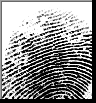

In [30]:
data[0]

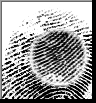

In [31]:
data[1]

In [33]:
data[2]

tensor(0)

In [36]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

def draw_images(images, classes):
    # 4x2의 그리드 생성 (바둑판 이미지 틀 생성)
    fig, axs = plt.subplots(4, 2, figsize=(12, 6))

    # 각 하위 그래프에 이미지 출력
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i]) # 이미지를 바둑판에 출력
        ax.set_title(classes[i]) # 클래스 이름으로 이미지 제목 생성
        # ax.axis('off') # 축 숨기기

    plt.tight_layout()
    plt.show()

In [39]:
from PIL import Image
import numpy as np
import random

def image_concat(image1, image2):
    width1, height1 = image1.size
    width2, height2 = image2.size
    new_width = width1 + width2
    new_height = max(height1, height2)

    concat_image = Image.new('RGB', (new_width, new_height))
    # 첫 번째 이미지를 새 이미지에 붙임
    concat_image.paste(image1, (0, 0))

    # 두 번째 이미지를 첫 번째 이미지 옆에 붙임
    concat_image.paste(image2, (width1, 0))

    return concat_image

In [40]:
random.shuffle(annotations)

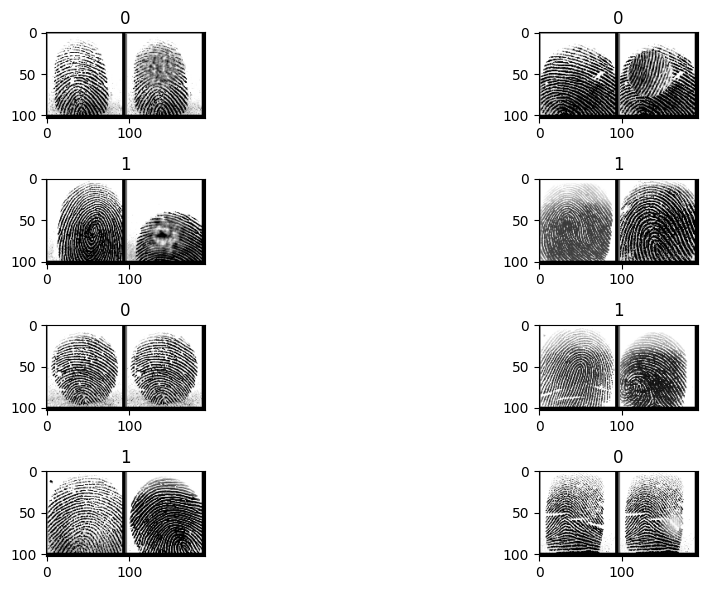

In [41]:
sample_images = [] # 이미지 샘플 저장
sample_classes = [] # 이미지 클래스 저장
sample_cnt = 0 # 시작 count
max_cnt = 8 # 종류 count
for annot in annotations:
    image1_path, image2_path, label = annot
    sample_classes.append(label)
    image1 = Image.open(image1_path).convert('RGB')
    image2 = Image.open(image2_path).convert('RGB')

    merged_image = image_concat(image1, image2)

    sample_images.append(merged_image)
    sample_cnt += 1
    if sample_cnt == max_cnt:
        break

## 전체 데이터 샘플을 시각화 한다.
draw_images(sample_images, sample_classes)

In [38]:
len_annot = len(annotations)
train_annot = annotations[ : int(len_annot * 0.9)]
val_annot = annotations[int(len_annot * 0.9) : ]

print(f'학습 데이터 개수 : {len(train_annot)}')
print(f'검증 데이터 개수 : {len(val_annot)}')

학습 데이터 개수 : 99486
검증 데이터 개수 : 11054


In [45]:
hyper_params = {
    'num_epochs': 3,
    'lr': 0.0001,
    'image_size': 128,
    'train_batch_size': 32,
    'val_batch_size': 16,
    'print_preq': 0.1 # 학습 중 로그 출력 빈도
}

In [46]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [51]:
# 샘플 이미지 변환 모듈 설정
sample_transform = A.Compose([
    A.ShiftScaleRotate(rotate_limit=15, shift_limit=0.05, scale_limit=0.1, p=0.5, border_mode=0),
    A.LongestMaxSize(max_size=hyper_params['image_size']),
    A.PadIfNeeded(min_height=hyper_params['image_size'],
                  min_width=hyper_params['image_size'], border_mode=0),
    # A.Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ## 이미지 픽셀 값 정규화
    # ToTensorV2() ## 모델에 입력할 때 사용
])

sample_dataset = PairDataset(annotations=annotations, transform=sample_transform)

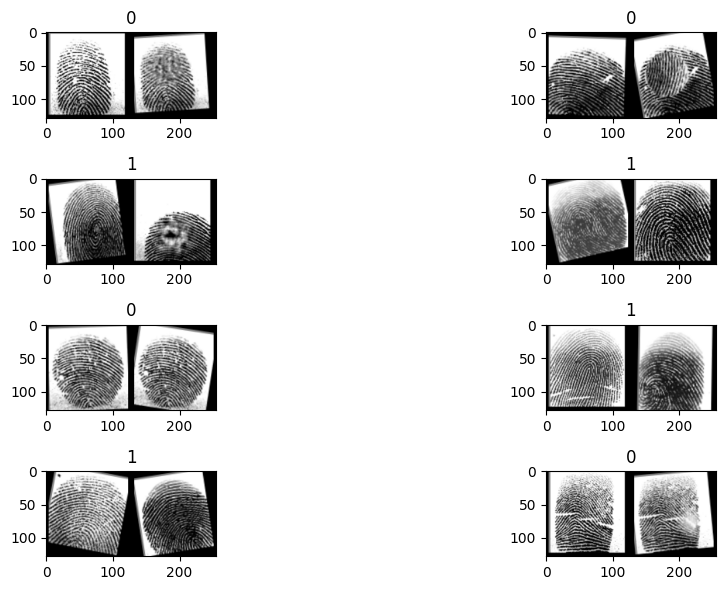

In [50]:
transformed_images = []
targets = []

## 데이터세트에서 변환된 이미지와 target 벡터를 불러온다.
max_cnt = 8
for idx, (image1, image2, target) in enumerate(sample_dataset):
    if idx == max_cnt:
        break
    merged_image = image_concat(Image.fromarray(image1), Image.fromarray(image2))
    transformed_images.append(np.array(merged_image))
    targets.append(int(target))

draw_images(transformed_images, targets)

In [52]:
# 학습 및 검증 이미지 변환 모듈 설정
train_transform = A.Compose([
    A.ShiftScaleRotate(rotate_limit=15, shift_limit=0.05, scale_limit=0.1, p=0.5, border_mode=0),
    A.LongestMaxSize(max_size=hyper_params['image_size']),
    A.PadIfNeeded(min_height=hyper_params['image_size'],
                  min_width=hyper_params['image_size'],
                  border_mode=0),
    A.Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ## 이미지 픽셀 값 정규화
    ToTensorV2() ## 모델에 입력할 때 사용
])

val_transform = A.Compose([
    A.LongestMaxSize(max_size=hyper_params['image_size']),
    A.PadIfNeeded(min_height=hyper_params['image_size'],
                  min_width=hyper_params['image_size'],
                  border_mode=0),
    A.Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ## 이미지 픽셀 값 정규화
    ToTensorV2() ## 모델에 입력할 때 사용
])

In [69]:
# 학습 데이터세트 및 데이터로더 설정
train_dataset = PairDataset(annotations=train_annot,
                            transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, num_workers=4, batch_size=hyper_params['train_batch_size'], shuffle=True)

# 검증 데이터세트 및 데이터로더 설정
val_dataset = PairDataset(annotations=val_annot,
                          transform=val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, num_workers=4, batch_size=hyper_params['val_batch_size'], shuffle=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [53]:
import torch
import torch.nn as nn
import timm
from torch.optim import Adam

In [54]:
class SiameseModel(nn.Module):
    def __init__(self):
        super(SiameseModel, self).__init__()
        # timm 라이브러리에서 ResNet18 모델 로드
        self.base_model = timm.create_model('resnet18', pretrained=True, num_classes=0)

    def forward_once(self, x):
        # 이미지를 통과시켜 특징 벡터 추출
        return self.base_model(x)

    def forward(self, input1, input2):
        # 두 이미지 각각을 모델에 통과시켜 특징 벡터를 얻음
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [55]:
model = SiameseModel()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [65]:
class ContrastiveLoss(nn.Module):
    # 서로 다른 클래스면 최소 1이상 떨어져야 한다는 기준
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

### ContrastiveLoss
* 쌍(pair) 데이터를 학습할 때 사용하는 손실 함수
* positive pair와 negative pair를 구분하는 거리 기반 방식
    * positive pair: 두 벡터가 가까워지도록
    * negative pair: 두 벡터가 멀어지도록

<img src="https://blog.kakaocdn.net/dna/RSNy1/btsQh192viy/AAAAAAAAAAAAAAAAAAAAAFyt8NvKwumPx_s2IcWDmDXtrXayeB4KBolqJdgsfvnx/img.png?credential=yqXZFxpELC7KVnFOS48ylbz2pIh7yKj8&expires=1759244399&allow_ip=&allow_referer=&signature=uMXpBIKhLSO0qnVJOcR3DW6Rm7c%3D">

> ContrastivaLoss는 positive는 가까워지게, negative는 margin 이상 벌어지게 학습시켜 지문처럼 쌍 비교를 하는 문제에 최적화된 손실 함수

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

In [70]:
# loss 함수와 옵티마이저 설정
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=hyper_params['lr'])

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = hyper_params['num_epochs']
model_save_dir = './fingerprint_train_results' # epoch 마다 모델 weight를 저장한다.
os.makedirs(model_save_dir, exist_ok=True)

# 학습
min_loss = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    print_cnt = int(len(train_dataloader) * hyper_params['print_preq'])

    for idx, (image1, image2, targets) in enumerate(train_dataloader):
        image1, image2, targets = image1.to(device), image2.to(device), targets.to(device)

        # 순전파
        output1, output2 = model(image1, image2)
        loss = criterion(output1, output2, targets)

        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()

        if idx % print_cnt == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Iter [{idx}/{len(train_dataloader)}] "
                  f"Loss: {running_loss/print_cnt:.4f}")
            running_loss = 0.0



    # 한 epoch이 끝날 때마다 손실값 출력
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_dataloader):.4f}")

    # 한 epoch이 끝날 때마다 model weight 저장
    model_save_path = os.path.join(model_save_dir, f'{epoch}_model.pth')
    torch.save(model.state_dict(), model_save_path)


    # return val_loss / len(dataloader)  # 평균 검증 손실 반환

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for image1, image2, targets in val_dataloader:
            image1, image2, targets = image1.to(device), image2.to(device), targets.to(device)
            output1, output2 = model(image1, image2)
            loss = criterion(output1, output2, targets)
            val_loss += loss.item()
    val_loss /= len(val_dataloader)

    if val_loss < min_loss:
        model_save_path = os.path.join(model_save_dir, f'best_model.pth')
        torch.save(model.state_dict(), model_save_path)
        min_loss = val_loss

    print(f"Val Loss : {val_loss:.4f}")

Epoch [1/3], Iter [0/3109] Loss: 0.1275
Epoch [1/3], Iter [310/3109] Loss: 4.7646
Epoch [1/3], Iter [620/3109] Loss: 0.3265
Epoch [1/3], Iter [930/3109] Loss: 0.2190
Epoch [1/3], Iter [1240/3109] Loss: 0.2096
Epoch [1/3], Iter [1550/3109] Loss: 0.1983
Epoch [1/3], Iter [1860/3109] Loss: 0.1798
Epoch [1/3], Iter [2170/3109] Loss: 0.1562
Epoch [1/3], Iter [2480/3109] Loss: 0.1312
Epoch [1/3], Iter [2790/3109] Loss: 0.1106
Epoch [1/3], Iter [3100/3109] Loss: 0.0995
Epoch [1/3], Loss: 0.6506
Val Loss : 0.0454
Epoch [2/3], Iter [0/3109] Loss: 0.0003
Epoch [2/3], Iter [310/3109] Loss: 0.0862
Epoch [2/3], Iter [620/3109] Loss: 0.0770
Epoch [2/3], Iter [930/3109] Loss: 0.0721
Epoch [2/3], Iter [1240/3109] Loss: 0.0652
Epoch [2/3], Iter [1550/3109] Loss: 0.0635
Epoch [2/3], Iter [1860/3109] Loss: 0.0576
Epoch [2/3], Iter [2170/3109] Loss: 0.0529
Epoch [2/3], Iter [2480/3109] Loss: 0.0490
Epoch [2/3], Iter [2790/3109] Loss: 0.0469
Epoch [2/3], Iter [3100/3109] Loss: 0.0444
Epoch [2/3], Loss: 0.0

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_path = os.path.join('./fingerprint_train_results', 'best_model.pth')

model = SiameseModel().eval().to(device)
model.load_state_dict(torch.load(weight_path))

feature_vector_list = []
with torch.no_grad():
    for filename in tqdm(src_filename_list):
        image_path = os.path.join(data_root, 'Real', filename)
        image = Image.open(image_path).convert('RGB')

        image = val_transform(image=np.array(image))['image'].unsqueeze(0).to(device)
        feature_vector = model.forward_once(image).detach().cpu().numpy()[0]
        feature_vector_list.append(feature_vector)
feature_vector_list = np.array(feature_vector_list)

100%|██████████| 6000/6000 [00:21<00:00, 278.00it/s]


In [72]:
print(f"전체 feature vector의 shape : {feature_vector_list.shape}")

전체 feature vector의 shape : (6000, 512)


In [73]:
dst_filenames = random.sample(dst_filename_list, 1)[0]
dst_filename = random.sample(dst_filenames, 1)[0]
dst_dir_list = ['Altered-Easy', 'Altered-Hard', 'Altered-Medium']
dst_dir = random.sample(dst_dir_list, 1)[0]


with torch.no_grad():
    image_path = os.path.join(data_root, 'Altered', dst_dir, dst_filename)
    image = Image.open(image_path).convert('RGB')

    image = val_transform(image=np.array(image))['image'].unsqueeze(0).to(device)
    query_vector = model.forward_once(image).detach().cpu().numpy()

In [74]:
# 벡터 간의 유클리드 거리를 계산
distances = np.linalg.norm(feature_vector_list - query_vector, axis=1)

# 가장 작은 거리의 인덱스 찾기
min_index = np.argmin(distances)
result = src_filename_list[min_index]

In [75]:
print(dst_filename)

546__M_Right_thumb_finger_Obl.BMP


In [76]:
print(result)

546__M_Right_thumb_finger.BMP


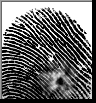

In [77]:
Image.open(image_path)

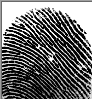

In [78]:
Image.open(os.path.join(data_root, 'Real', result))